# Calibrating and Binning Ariel Data

**UPDATE**
N/A

# PLEAES READ BEFORE YOU PROCEED
1. within the wall time. From experience, GPU acceleration, Parallelisation and other coding language will help. We encourage the kaggle community to share their calibration scripts to help speed up this process.  

2. We have also only processed the 1st observation of every planet, not their repeats, so you might want to also take that into account. 

3. While these steps help reduce noise and data size, they may not be the most effective approach for achieving the optimal model for this challenge. Participants are encouraged to explore different combinations of these steps, or other approaches, to clean up the data.

This notebook follows largely from the [ADC2024 edition](https://www.kaggle.com/code/gordonyip/update-calibrating-and-binning-astronomical-data), with minor updates to reflect changes made. 

Data reduction is crucial in astronomical observations. This notebook outlines essential calibration steps typically employed by astronomers to mitigate noise in data. We want to emphasis that these steps are NOT laws or rules you must take. Take them as a general recipe where you can always add/delete things. 

Key points:

- The notebook guides participants through pre-processing data and saving it in a more convenient, lighter format.
- Similar to last year, if you plan to use the baseline models (which will be released soon), you must run this notebook first before training.





**Acknowledgement**: This notebook is modified by Gordon Yip from its 2024 version prepared by Angèle Syty and Virginie Batista (IAP), with support from Andrea Bocchieri (Sapienza Università di Roma
), Orphée Faucoz (CNES), Lorenzo V. Mugnai (Cardiff University & UCL), Tara Tahseen (UCL) and the Kaggle community.

Last modified: 27th Jun 2025. 

In [1]:
import numpy as np
import pandas as pd
import itertools
import os
import glob 
from astropy.stats import sigma_clip

from tqdm import tqdm

Below, we define the corrections we want to apply, the size of the data chunks and the different path used to import data and save the light ones. 

In [2]:

path_folder = '/kaggle/input/ariel-data-challenge-2025/' # path to the folder containing the data
path_out = '/kaggle/tmp/data_light_raw/' # path to the folder to store the light data
output_dir = '/kaggle/tmp/data_light_raw/' # path for the output directory

If the *path_out* folder doesn't exist yet, it is created. 

In [3]:
if not os.path.exists(path_out):
    os.makedirs(path_out)
    print(f"Directory {path_out} created.")
else:
    print(f"Directory {path_out} already exists.")


Directory /kaggle/tmp/data_light_raw/ created.


**Data import:**

 The files are imported by chunks of size 'CHUNK_SIZE' to avoid exceeding the memory capacity. 

In [4]:
CHUNKS_SIZE = 1

## Step 1: Analog-to-Digital Conversion

The Analog-to-Digital Conversion (adc) is performed by the detector to convert the pixel voltage into an integer number. We revert this operation by using the gain and offset for the calibration files 'train_adc_info.csv'.


In [5]:
def ADC_convert(signal, gain=0.4369, offset=-1000):
    """The Analog-to-Digital Conversion (adc) is performed by the detector to convert
    the pixel voltage into an integer number. Since we are using the same conversion number 
    this year, we have simply hard-coded it inside. """
    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset
    return signal

## Step 2: Mask hot/dead pixel
The dead pixels map is a map of the pixels that do not respond to light and, thus, can’t be accounted for any calculation. In all these frames the dead pixels are masked using python masked arrays. The bad pixels are thus masked but left uncorrected. Some methods can be used to correct bad-pixels but this task, if needed, is left to the participants.

In [6]:
def mask_hot_dead(signal, dead, dark):
    hot = sigma_clip(
        dark, sigma=5, maxiters=5
    ).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)
    return signal

## Step 2: linearity Correction



**Non-linearity of pixels' response:**

The non-linearity of the pixels’ response can be explained as capacitive leakage on the readout electronics of each pixel during the integration time. The number of electrons in the well is proportional to the number of photons that hit the pixel, with a quantum efficiency coefficient. However, the response of the pixel is not linear with the number of electrons in the well. This effect can be described by a polynomial function of the number of electrons actually in the well. The data is provided with calibration files linear_corr.parquet that are the coefficients of the inverse polynomial function and can be used to correct this non-linearity effect.



In [7]:
def apply_linear_corr(linear_corr,clean_signal):
    linear_corr = np.flip(linear_corr, axis=0)
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    return clean_signal
    

## Step 3: dark current subtraction

The data provided include calibration for dark current estimation, which can be used to pre-process the observations. Dark current represents a constant signal that accumulates in each pixel during the integration time, independent of the incoming light. To obtain the corrected image, the following conventional approach is applied: The data provided include calibration files such as dark frames or dead pixels' maps. They can be used to pre-process the observations. The dark frame is a map of the detector response to a very short exposure time, to correct for the dark current of the detector.
$$\text{image - dark} \times \Delta t $$ 
The corrected image is conventionally obtained via the following: where the dark current map is first corrected for the dead pixel.

In [8]:
def clean_dark(signal, dead, dark, dt):

    dark = np.ma.masked_where(dead, dark)
    dark = np.tile(dark, (signal.shape[0], 1, 1))

    signal -= dark* dt[:, np.newaxis, np.newaxis]
    return signal


## Step 4: Get Correlated Double Sampling (CDS)

The science frames are alternating between the start of the exposure and the end of the exposure. The lecture scheme is a ramp with a double sampling, called Correlated Double Sampling (CDS), the detector is read twice, once at the start of the exposure and once at the end of the exposure. The final CDS is the difference (End of exposure) - (Start of exposure).

In [9]:
def get_cds(signal):
    cds = signal[:,1::2,:,:] - signal[:,::2,:,:]
    return cds

## Step 5 (Optional): Time Binning
This step is performed mianly to save space. Time series observations are binned together at specified frequency. 



In [10]:
def bin_obs(cds_signal,binning):
    cds_transposed = cds_signal.transpose(0,1,3,2)
    cds_binned = np.zeros((cds_transposed.shape[0], cds_transposed.shape[1]//binning, cds_transposed.shape[2], cds_transposed.shape[3]))
    for i in range(cds_transposed.shape[1]//binning):
        cds_binned[:,i,:,:] = np.sum(cds_transposed[:,i*binning:(i+1)*binning,:,:], axis=1)
    return cds_binned

## Step 6: Flat Field Correction


The flat field is a map of the detector response to uniform illumination, to correct for the pixel-to-pixel variations of the detector, for example the different quantum efficiencies of each pixel.

In [11]:
def correct_flat_field(flat,dead, signal):
    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal = signal / flat
    return signal

# Calibrating all training data

you can choose to correct the non-linearity of the pixels' response, to apply flat field, dark and dead map or to leave the data unchanged. The observations are binned in time by group of 30 frames for AIRS and 360 frames for FGS1, to obtain a lighter data-cube, easier to use. The images are cut along the wavelength axis between pixels 39 and 321, so that the 282 pixels left in the wavelength dimension match the last 282 targets' points, from AIRS. The 283rd targets' point is the one for FGS1 that will be added later on. 

In [12]:
## we will start by getting the index of the training data:
def get_index(files,CHUNKS_SIZE ):
    index = []
    for file in files:
        file_name = file.split('/')[-1]
        if file_name.split('_')[0] == 'AIRS-CH0' and file_name.split('_')[1] == 'signal' and file_name.split('_')[2] == '0.parquet':
            file_index = os.path.basename(os.path.dirname(file))
            index.append(int(file_index))
    index = np.array(index)
    index = np.sort(index) 
    # credit to DennisSakva
    index=np.array_split(index, len(index)//CHUNKS_SIZE)
    
    return index

In [13]:
files = glob.glob(os.path.join(path_folder + 'train/', '*/*'))

index = get_index(files[:300],CHUNKS_SIZE)  ## 22 is hardcoded here but please feel free to remove it if you want to do it for the entire dataset

axis_info = pd.read_parquet(os.path.join(path_folder,'axis_info.parquet'))
DO_MASK = True
DO_THE_NL_CORR = False
DO_DARK = True
DO_FLAT = True
TIME_BINNING = True

cut_inf, cut_sup = 39, 321
l = cut_sup - cut_inf

for n, index_chunk in enumerate(tqdm(index)):
    AIRS_CH0_clean = np.zeros((CHUNKS_SIZE, 11250, 32, l))
    FGS1_clean = np.zeros((CHUNKS_SIZE, 135000, 32, 32))
    
    for i in range (CHUNKS_SIZE) : 
        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_signal_0.parquet'))
        signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))

        signal = ADC_convert(signal,)
        dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
        dt_airs[1::2] += 0.1
        chopped_signal = signal[:, :, cut_inf:cut_sup]
        del signal, df
        
        # CLEANING THE DATA: AIRS
        flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/dark.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dead_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/dead.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]
        
        if DO_MASK:
            chopped_signal = mask_hot_dead(chopped_signal, dead_airs, dark)
            AIRS_CH0_clean[i] = chopped_signal
        else:
            AIRS_CH0_clean[i] = chopped_signal
            
        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr,AIRS_CH0_clean[i])
            AIRS_CH0_clean[i,:, :, :] = linear_corr_signal
        del linear_corr
        
        if DO_DARK: 
            cleaned_signal = clean_dark(AIRS_CH0_clean[i], dead_airs, dark, dt_airs)
            AIRS_CH0_clean[i] = cleaned_signal
        else: 
            pass
        del dark
        
        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_signal_0.parquet'))
        fgs_signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 32))

        
        fgs_signal = ADC_convert(fgs_signal, )
        dt_fgs1 = np.ones(len(fgs_signal))*0.1
        dt_fgs1[1::2] += 0.1
        chopped_FGS1 = fgs_signal
        del fgs_signal, df
        
        # CLEANING THE DATA: FGS1
        flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/flat.parquet')).values.astype(np.float64).reshape((32, 32))
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/dark.parquet')).values.astype(np.float64).reshape((32, 32))
        dead_fgs1 = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/dead.parquet')).values.astype(np.float64).reshape((32, 32))
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 32))
        
        if DO_MASK:
            chopped_FGS1 = mask_hot_dead(chopped_FGS1, dead_fgs1, dark)
            FGS1_clean[i] = chopped_FGS1
        else:
            FGS1_clean[i] = chopped_FGS1

        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr,FGS1_clean[i])
            FGS1_clean[i,:, :, :] = linear_corr_signal
        del linear_corr
        
        if DO_DARK: 
            cleaned_signal = clean_dark(FGS1_clean[i], dead_fgs1, dark,dt_fgs1)
            FGS1_clean[i] = cleaned_signal
        else: 
            pass
        del dark
        
    # SAVE DATA AND FREE SPACE
    AIRS_cds = get_cds(AIRS_CH0_clean)
    FGS1_cds = get_cds(FGS1_clean)
    
    del AIRS_CH0_clean, FGS1_clean
    
    ## (Optional) Time Binning to reduce space
    if TIME_BINNING:
        AIRS_cds_binned = bin_obs(AIRS_cds,binning=30)
        FGS1_cds_binned = bin_obs(FGS1_cds,binning=30*12)
    else:
        AIRS_cds = AIRS_cds.transpose(0,1,3,2) ## this is important to make it consistent for flat fielding, but you can always change it
        AIRS_cds_binned = AIRS_cds
        FGS1_cds = FGS1_cds.transpose(0,1,3,2)
        FGS1_cds_binned = FGS1_cds
    
    del AIRS_cds, FGS1_cds
    
    for i in range (CHUNKS_SIZE):
        flat_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        flat_fgs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/flat.parquet')).values.astype(np.float64).reshape((32, 32))
        if DO_FLAT:
            corrected_AIRS_cds_binned = correct_flat_field(flat_airs,dead_airs, AIRS_cds_binned[i])
            AIRS_cds_binned[i] = corrected_AIRS_cds_binned
            corrected_FGS1_cds_binned = correct_flat_field(flat_fgs,dead_fgs1, FGS1_cds_binned[i])
            FGS1_cds_binned[i] = corrected_FGS1_cds_binned
        else:
            pass

    ## save data
    np.save(os.path.join(path_out, 'AIRS_clean_train_{}.npy'.format(n)), AIRS_cds_binned)
    np.save(os.path.join(path_out, 'FGS1_train_{}.npy'.format(n)), FGS1_cds_binned)
    del AIRS_cds_binned
    del FGS1_cds_binned

100%|██████████| 62/62 [18:35<00:00, 18.00s/it]


Once all the chunks are saved, we concatenate them back in a single dataset. This step is simply to save HDD space, modify it as you wish. 

In [14]:
def load_data (file, chunk_size, nb_files) : 
    data0 = np.load(file + '_0.npy')
    data_all = np.zeros((nb_files*chunk_size, data0.shape[1], data0.shape[2], data0.shape[3]))
    data_all[:chunk_size] = data0
    for i in range (1, nb_files) : 
        data_all[i*chunk_size:(i+1)*chunk_size] = np.load(file + '_{}.npy'.format(i))
    return data_all 

data_train = load_data(path_out + 'AIRS_clean_train', CHUNKS_SIZE, len(index)) 
data_train_FGS = load_data(path_out + 'FGS1_train', CHUNKS_SIZE, len(index))


In [15]:
np.save('./' + 'data_train.npy', data_train)
np.save('./' + 'data_train_FGS.npy', data_train_FGS)

# Plots

Let us checks that everything went well during the data import. 

In [16]:
import matplotlib.pyplot as plt 

print('Shape of the training datasset: \t')
print('\n For AIRS-CH0:', data_train.shape)
print('\n For FGS1:', data_train_FGS.shape)



Shape of the training datasset: 	

 For AIRS-CH0: (62, 187, 282, 32)

 For FGS1: (62, 187, 32, 32)


Plot of some images: 

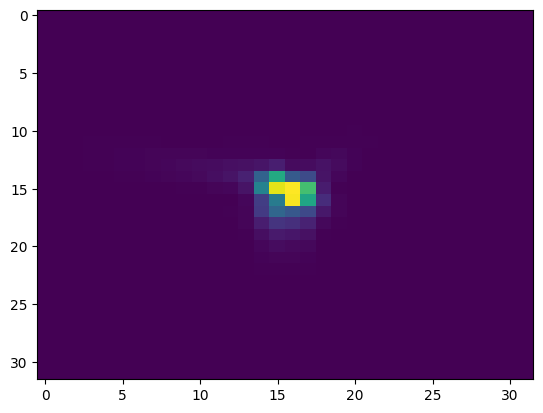

In [17]:
plt.imshow(data_train_FGS[-1,50,:,:].T, aspect = 'auto')

Plot of some light-curves: 

Text(0, 0.5, 'Normalized flux in the frame')

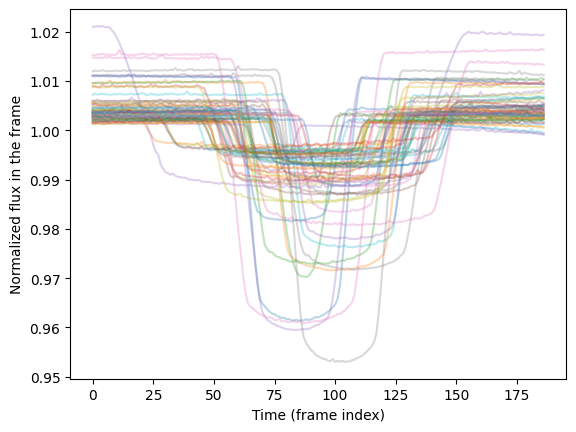

In [18]:

for i in range(len(data_train)) : 
    light_curve = data_train[i,:,:,:].sum(axis=(1,2))
    plt.plot(light_curve/light_curve.mean(), '-', alpha=0.3)

plt.xlabel('Time (frame index)')
plt.ylabel('Normalized flux in the frame')